In [161]:
%load_ext autoreload
%autoreload 2

%pylab inline
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

import eternabench as eb
from RiboGraphViz import RGV
from scipy.stats import spearmanr, pearsonr

#draw_rna
from ipynb.draw import draw_struct

import logomaker

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In this notebook:

- [x] Figure 1B -- Cloud lab project metadata

- [x] Figure 1D -- Cloud lab dataset statistics

- [x] Figure S3 -- Cloud lab filtering descriptive stats

- [ ] Figure S6 -- Correlations of Dataset statistics and mean package correlation

- [x] Figure S14 -- EternaFold train/holdout descriptive stats



In [5]:
df = eb.load_CM_unfiltered_data()

Loading EternaBench ChemMapping FULL dataset (n=41876), last update Jul 08 2021


In [7]:
df['GC content'] = [(x.count('G')+x.count('C'))/len(x) for x in df['sequence']]
df['Length'] = [len(x)-21 for x in df['sequence']]
df['signal_to_noise'] = [float(x.split(':')[-1]) for x in df['signal_to_noise']]

def get_RGV_stats(row):
    try:
        mdl = RGV(row['structure'])
        mdl.run_structure_properties()
        loop_count = len(list([x for x in mdl.G.nodes if isinstance(x, int)]))-1
        return loop_count, np.clip(mdl.n_hairpins,0,100), mdl.n_internal_loops, mdl.n_3WJs + mdl.n_4WJs+ mdl.n_5WJs_up
    except:
        struct = row['structure'].replace('))(((((((....))))))).....................','..(((((((....))))))).....................')
        mdl = RGV(struct)
        mdl.run_structure_properties()
        loop_count = len(list([x for x in mdl.G.nodes if isinstance(x, int)]))-1
        return loop_count, np.clip(mdl.n_hairpins,0,100), mdl.n_internal_loops, mdl.n_3WJs + mdl.n_4WJs + mdl.n_5WJs_up
    
unique_struct_df = pd.DataFrame({'structure': [x for x in set(df.structure)]}) 
unique_struct_df[['Target structure, total loops', 'Target structure, # hairpins','Target structure, # Internal loops','Target structure, # Multiloops']] =\
unique_struct_df.apply(lambda row: get_RGV_stats(row), axis=1, result_type='expand')
df = df.merge(unique_struct_df, on='structure')

In [134]:
project_scores = pd.read_csv('/Users/hwayment/das/EternaBench/scoring_data/Apr17byproj_pearson_summarystats.csv')
project_variance = project_scores.groupby(['project_name'])['mean'].std()
project_variance = project_variance.reset_index()
project_variance['Stddev_of_package_predictions'] = project_variance['mean']
project_variance = project_variance.drop(columns=['mean'])

In [142]:
project_scores

,project_name,package,mean,std,size
0,"""Magic"" boosts in 2-2 loops",contrafold_1,0.624687,0.014600,1000
1,"""Magic"" boosts in 2-2 loops",contrafold_2,0.587924,0.017525,1000
2,"""Magic"" boosts in 2-2 loops",contrafold_2_nc,0.541981,0.018059,1000
3,"""Magic"" boosts in 2-2 loops",eternafold_A,0.584261,0.017690,1000
4,"""Magic"" boosts in 2-2 loops",eternafold_B,0.585775,0.017541,1000
...,...,...,...,...,...
10969,Ziggy 25 (aka Multiloop Test),vienna_2,0.445058,0.015112,1000
10970,Ziggy 25 (aka Multiloop Test),vienna_2_60C,0.500803,0.012920,1000
10971,Ziggy 25 (aka Multiloop Test),vienna_2_nodangles,0.416348,0.015075,1000
10972,Ziggy 25 (aka Multiloop Test),vienna_langdon_pars,0.523931,0.013145,1000


In [135]:
def create_project_stats(df):
    project_stats = df.groupby(['Dataset','project_name']).mean()
    project_sizes = df.groupby(['Dataset','project_name'])['sequence'].size()

    project_sizes = project_sizes.reset_index()
    project_stats = project_stats.reset_index()
    project_stats['# constructs'] = project_sizes['sequence']
    project_stats = project_stats.loc[~project_stats.Dataset.isna()]
    project_stats = project_stats.loc[project_stats.Dataset!='RYOS_I']
    
    proj_entropies = pd.DataFrame()
    for proj_name in df.project_name.unique():
        if proj_name is not None:
            seqs = [x for x in df.loc[df.project_name==proj_name]['sequence']]
            n_lengths = len(list(set([len(x) for x in seqs])))
            if n_lengths == 1:
                entropy = eb.sequence_analysis.positional_entropy(seqs)
                proj_entropies = proj_entropies.append({'project_name': proj_name, 'Sequence Entropy': entropy}, ignore_index=True)

    project_stats = project_stats.merge(proj_entropies, on='project_name',how='left')
    return project_stats

proj_stats = create_project_stats(df)
proj_stats_filt = create_project_stats(df.loc[df.passed_CDHIT_filter==True])
proj_stats_filt = proj_stats_filt.merge(project_variance,on='project_name',how='left')

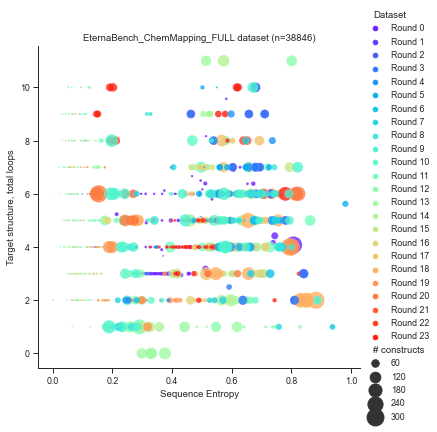

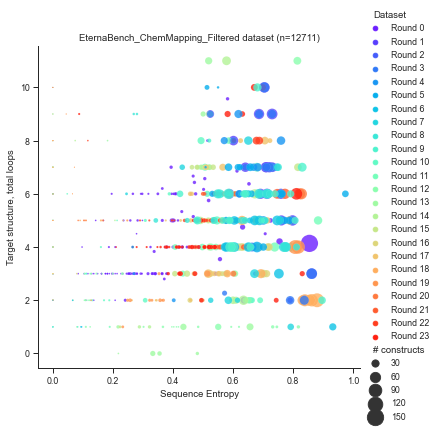

In [139]:
tmp_order=['Round 0', 'Round 1','Round 2','Round 3','Round 4','Round 5','Round 6','Round 7','Round 8',
'Round 9','Round 10','Round 11','Round 12','Round 13','Round 14','Round 15','Round 16','Round 17',
'Round 18','Round 19','Round 20','Round 21','Round 22','Round 23']

sns.relplot(x='Sequence Entropy',y='Target structure, total loops', data=proj_stats,
            size='# constructs',hue='Dataset',palette='rainbow',sizes=(1,300), hue_order=tmp_order,alpha=0.8)
title('EternaBench_ChemMapping_FULL dataset (n=38846)')
savefig('FIGURES/1/CloudLab_bubble_plot.pdf',bbox_inches='tight')

sns.relplot(x='Sequence Entropy',y='Target structure, total loops', data=proj_stats_filt,
            size='# constructs',hue='Dataset',palette='rainbow',sizes=(1,300), hue_order=tmp_order,alpha=0.8)

title('EternaBench_ChemMapping_Filtered dataset (n=12711)')
savefig('FIGURES/1/CloudLab_bubble_plot_filtered.pdf',bbox_inches='tight')


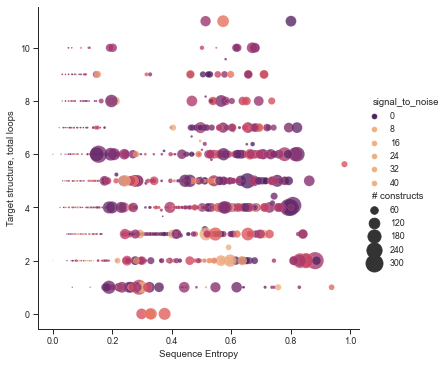

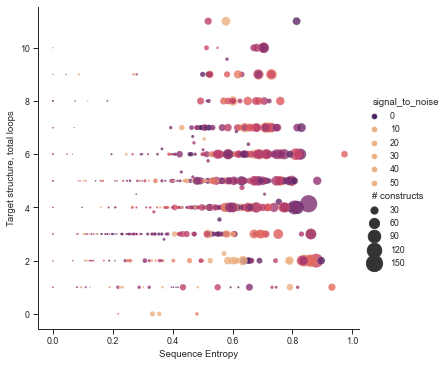

In [140]:
sns.relplot(x='Sequence Entropy',y='Target structure, total loops', data=proj_stats,
            size='# constructs',hue='signal_to_noise',palette='flare_r',sizes=(1,300), hue_norm=(0,8), alpha=0.8)
savefig('FIGURES/extra/CloudLab_bubble_plot_SignalNoise.pdf',bbox_inches='tight')

sns.relplot(x='Sequence Entropy',y='Target structure, total loops', data=proj_stats_filt,
            size='# constructs',hue='signal_to_noise',palette='flare_r',sizes=(1,300), hue_norm=(0,8), alpha=0.8)
savefig('FIGURES/extra/CloudLab_bubble_plot_SignalNoise_filtered.pdf',bbox_inches='tight')


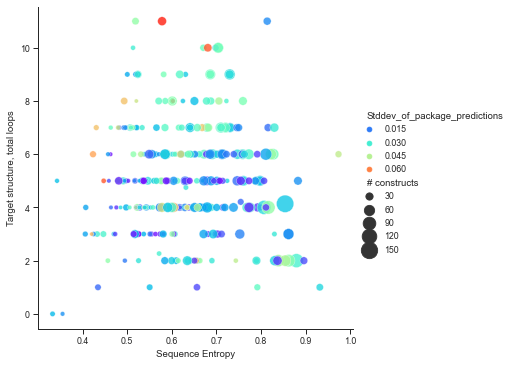

In [141]:
sns.relplot(x='Sequence Entropy',y='Target structure, total loops', data=proj_stats_filt,
            size='# constructs',hue='Stddev_of_package_predictions',palette='rainbow',sizes=(1,300), hue_order=tmp_order,alpha=0.8)

savefig('FIGURES/extra/CloudLab_bubble_plot_SignalNoise.pdf',bbox_inches='tight')


Text(0.5, 1.0, 'Spearman R=0.25, p = 7.74E-07')

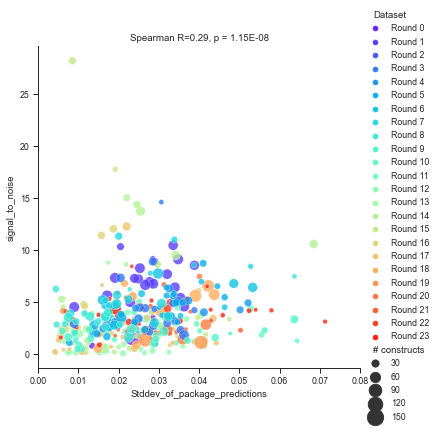

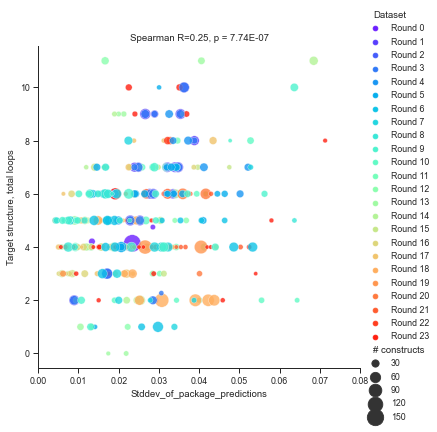

In [166]:
sns.relplot(x='Stddev_of_package_predictions',y='signal_to_noise', data=proj_stats_filt,
            size='# constructs',hue='Dataset',palette='rainbow',sizes=(1,300), hue_order=tmp_order,alpha=0.8)

r, p = spearmanr(proj_stats_filt['Stddev_of_package_predictions'], proj_stats_filt['signal_to_noise'],nan_policy='omit')
xlim([0,0.08])
title('Spearman R=%.2f, p = %.2E' % (r,p) )

sns.relplot(x='Stddev_of_package_predictions',y='Target structure, total loops', data=proj_stats_filt,
            size='# constructs',hue='Dataset',palette='rainbow',sizes=(1,300), hue_order=tmp_order,alpha=0.8)

r, p = spearmanr(proj_stats_filt['Stddev_of_package_predictions'], proj_stats_filt['Target structure, total loops'],nan_policy='omit')
xlim([0,0.08])
title('Spearman R=%.2f, p = %.2E' % (r,p) )

In [164]:
proj_stats_filt.corr(method='spearman')

,passed_CDHIT_filter,signal_to_noise,EternaScore,GC content,Length,"Target structure, total loops","Target structure, # hairpins","Target structure, # Internal loops","Target structure, # Multiloops",# constructs,Sequence Entropy,Stddev_of_package_predictions
passed_CDHIT_filter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
signal_to_noise,NaN,1.000000,0.275774,0.114071,-0.395613,-0.060642,-0.019239,-0.061782,-0.030683,-0.140150,-0.206365,0.290096
EternaScore,NaN,0.275774,1.000000,-0.075741,-0.107394,-0.154237,-0.009637,-0.189320,-0.027657,0.112731,0.063210,-0.164135
GC content,NaN,0.114071,-0.075741,1.000000,-0.015552,0.435610,0.295760,0.163257,0.257071,0.004453,0.029162,0.087644
Length,NaN,-0.395613,-0.107394,-0.015552,1.000000,0.395276,0.304720,0.183576,0.320133,0.248248,0.318417,0.090763
"Target structure, total loops",NaN,-0.060642,-0.154237,0.435610,0.395276,1.000000,0.608192,0.627689,0.579703,0.161596,0.161368,0.252564
"Target structure, # hairpins",NaN,-0.019239,-0.009637,0.295760,0.304720,0.608192,1.000000,-0.145916,0.956324,0.253194,0.211334,0.161810
"Target structure, # Internal loops",NaN,-0.061782,-0.189320,0.163257,0.183576,0.627689,-0.145916,1.000000,-0.167800,-0.070183,-0.038101,0.080108
"Target structure, # Multiloops",NaN,-0.030683,-0.027657,0.257071,0.320133,0.579703,0.956324,-0.167800,1.000000,0.255014,0.212979,0.157408
# constructs,NaN,-0.140150,0.112731,0.004453,0.248248,0.161596,0.253194,-0.070183,0.255014,1.000000,0.940358,0.055134


In [153]:
proj_stats_filt

Signature: spearmanr(a, b=None, axis=0, nan_policy='propagate')
Docstring:
Calculate a Spearman correlation coefficient with associated p-value.

The Spearman rank-order correlation coefficient is a nonparametric measure
of the monotonicity of the relationship between two datasets. Unlike the
Pearson correlation, the Spearman correlation does not assume that both
datasets are normally distributed. Like other correlation coefficients,
this one varies between -1 and +1 with 0 implying no correlation.
Correlations of -1 or +1 imply an exact monotonic relationship. Positive
correlations imply that as x increases, so does y. Negative correlations
imply that as x increases, y decreases.

The p-value roughly indicates the probability of an uncorrelated system
producing datasets that have a Spearman correlation at least as extreme
as the one computed from these datasets. The p-values are not entirely
reliable but are probably reasonable for datasets larger than 500 or so.

Parameters
---------

(0.0, 68.0)

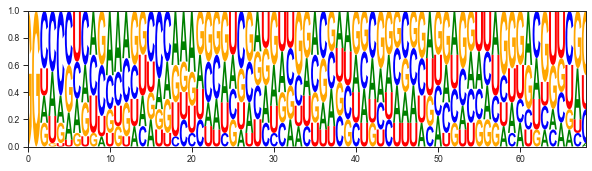

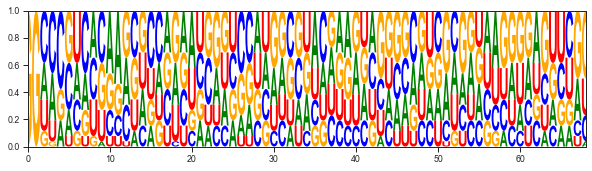

In [121]:
ex_low_entropy='Permuted loops'
seqs_pre_filt = df.loc[df.project_name==ex_low_entropy]['sequence'].values
seqs_post_filt = df.loc[df.passed_CDHIT_filter==True][df.project_name==ex_low_entropy]['sequence'].values

seqlogo = eb.sequence_analysis.make_logomaker_df(seqs_pre_filt)
logomaker.Logo(seqlogo)
xlim([0,68])


seqlogo = eb.sequence_analysis.make_logomaker_df(seqs_post_filt)
logomaker.Logo(seqlogo)
xlim([0,68])


In [116]:
proj_stats.loc[proj_stats['Target structure, total loops']==6][proj_stats['# constructs']>50].sort_values('Sequence Entropy')[:20].project_name

916     Lab Entry Level 0 - Bulge Cross revisited - Fr...
915     Lab Entry Level 0 - Bulge Cross revisited - Fr...
1191                                          sgRNA89_NGS
1192                                             tracrRNA
1162                          Codon riboswitch [arginine]
931     Lab Entry Level 0 - The Asymmetry lab revisite...
930     Lab Entry Level 0 - The Asymmetry lab revisite...
1186                                       Short Stacks 3
202                                        Large GU stack
1146        Location Dependent Chemical Footprints Part 3
1145        Location Dependent Chemical Footprints Part 1
287                             Unmodified tRNA sequences
1085                                         RNA Strength
188     Cloud Lab 7 - 5 Fold Radial Asymmetrical Starf...
1051    Cloud Lab 7 - 5 Fold Radial Asymmetrical Starf...
1059                                EzFold by space_miser
1174        Location Dependent Chemical Footprints Part 2
601           

In [120]:
proj_stats_filt.sort_values('Sequence Entropy', ascending=False)

,Dataset,project_name,passed_CDHIT_filter,signal_to_noise,EternaScore,GC content,Length,"Target structure, total loops","Target structure, # hairpins","Target structure, # Internal loops","Target structure, # Multiloops",# constructs,Sequence Entropy,EternaBench
817,Round 5,Permuted loops,True,5.493615,NaN,0.509972,87.00000,6.0,1.884615,3.384615,0.730769,26,0.973727,Filtered (n=12711)
838,Round 6,Caulobacter ncRNA discovery,True,5.833567,90.360000,0.537072,86.00000,1.0,1.000000,0.000000,0.000000,30,0.931785,Filtered (n=12711)
914,Round 9,Palindromes part one,True,0.511242,81.327273,0.397338,86.00000,2.0,1.000000,1.000000,0.000000,33,0.896056,Filtered (n=12711)
254,Round 11,Don Quixote,True,2.347625,90.485000,0.414231,109.00000,5.0,2.000000,2.000000,1.000000,40,0.882817,Filtered (n=12711)
600,Round 18,20% Non Watson-Crick Base Pairs - Effortless,True,4.205093,86.321296,0.393700,81.00000,2.0,1.000000,1.000000,0.000000,108,0.879450,Filtered (n=12711)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,Round 5,caulobacter_ncrna_lists,True,0.736750,NaN,0.568915,79.50000,1.0,1.000000,0.000000,0.000000,4,NaN,Filtered (n=12711)
850,Round 6,RNA windows pilot project - 16s rRNA (3I1M),True,7.767922,96.428125,0.474165,85.71875,1.0,1.000000,0.000000,0.000000,64,NaN,Filtered (n=12711)
871,Round 7,PSTVd probing,True,7.016300,93.620000,0.466306,67.90000,1.0,1.000000,0.000000,0.000000,10,NaN,Filtered (n=12711)
916,Round 9,Repeat hairpins v1,True,3.543100,91.940000,0.400093,88.80000,1.0,1.000000,0.000000,0.000000,10,NaN,Filtered (n=12711)


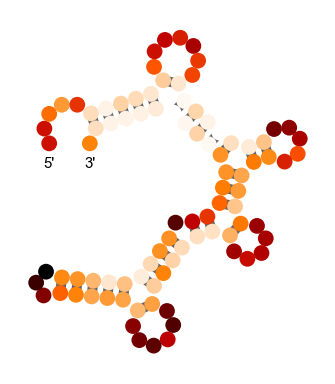

35


<Figure size 432x288 with 0 Axes>

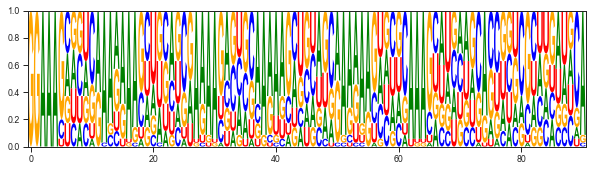

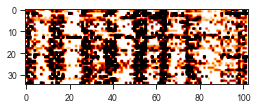

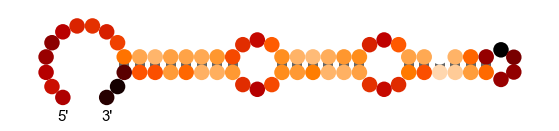

167


<Figure size 432x288 with 0 Axes>

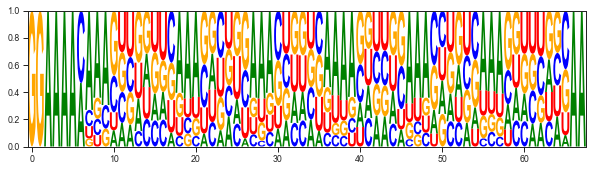

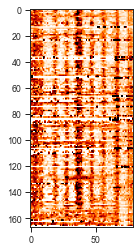

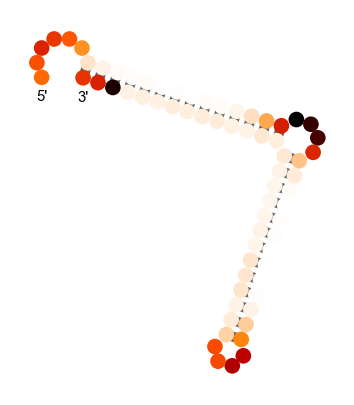

128
ERROR: pairing incorrect .....((((.((((((((((...))).))))))))))).....((((((.((((((((....))))).)
ERROR: pairing incorrect .....((((.((((((((((...))).))))))))))).....((((((.((((((((....))))).)


<Figure size 432x288 with 0 Axes>

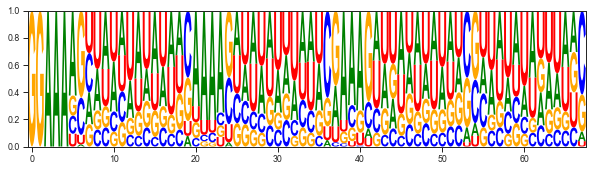

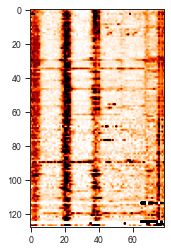

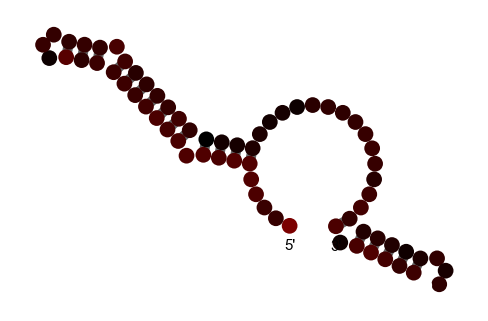

26


<Figure size 432x288 with 0 Axes>

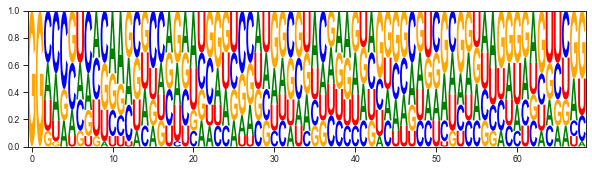

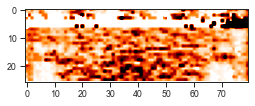

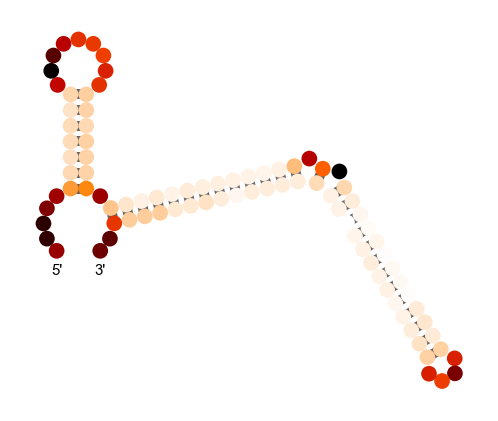

40


<Figure size 432x288 with 0 Axes>

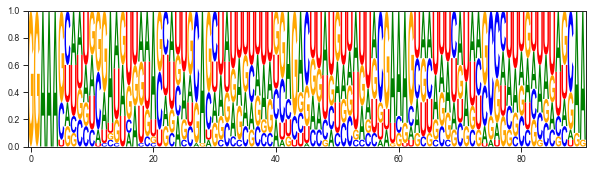

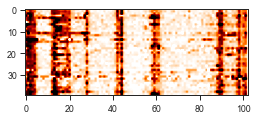

In [122]:
# Visualize subset of projects

project_list = ['New Frontier 3', 'Shape Library 101: The Finger','Cloud Lab 1 - Aires by wateronthemoon', 'Permuted loops', 'Don Quixote']

for proj in project_list:
    tmp = df.loc[df.passed_CDHIT_filter==True].loc[df.project_name==proj]
    cat_reac_data = np.vstack([x for x in tmp['reactivity']])
    struct = tmp.iloc[0]['structure'][:-39]
    reac_mean = np.mean(cat_reac_data, axis=0)[:len(struct)]
    draw_struct(' '*len(struct), struct, c = reac_mean, cmap='gist_heat_r')
    print(len(tmp))
    savefig('FIGURES/1/'+proj+'reac_on_struct.pdf',bbox_inches='tight')
    seqs = [x[:-39] for x in tmp.sequence]
    seqlogo = eb.sequence_analysis.make_logomaker_df(seqs)
    logomaker.Logo(seqlogo)
    figure(figsize=(4,4))
    imshow(cat_reac_data, cmap='gist_heat_r',vmin=0,vmax=1.5)
    savefig('FIGURES/1/'+proj+'reac_heatmap.pdf',bbox_inches='tight')

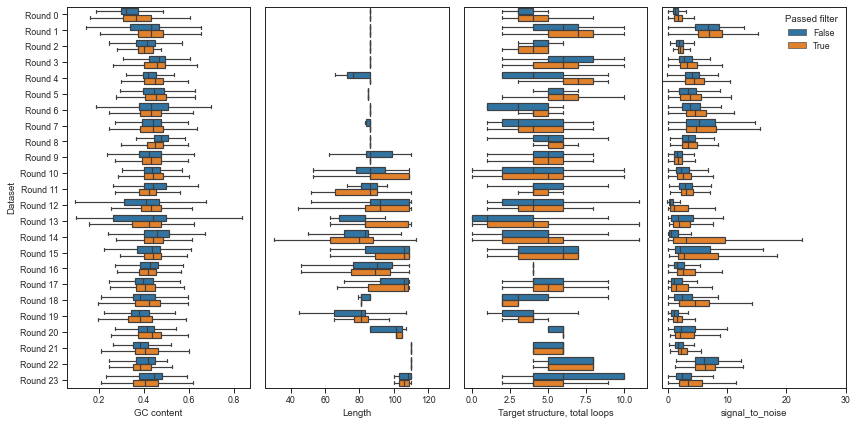

In [75]:
figure(figsize=(12,6))

# proj_stats['EternaBench']='Full (n=38846)'
# proj_stats_filt['EternaBench']='Filtered (n=12711)'
# tmp = pd.concat([proj_stats, proj_stats_filt])

for i, metric in enumerate(['GC content','Length','Target structure, total loops','signal_to_noise']):
    subplot(1,4,i+1)
    sns.boxplot(y='Dataset', x=metric, data=df, order=tmp_order, hue='passed_CDHIT_filter', fliersize=0)
    if i!= 0:
        yticks([])
        ylabel('')
    if i!=3:
        legend([], frameon=False)
    else:
        legend(frameon=False,title='Passed filter')
        xlim([-1, 30])
tight_layout()
savefig('FIGURES/SI/Figure_S3.pdf',bbox_inches='tight')
savefig('FIGURES/SI/Figure_S3.png',dpi=300, bbox_inches='tight')

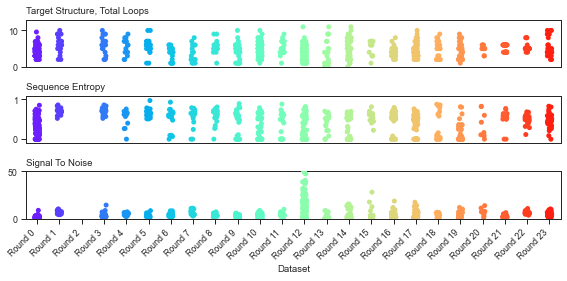

In [51]:
figure(figsize=(8,4))

ymaxes=[13,1.1, 50]
for i, metric in enumerate(['Target structure, total loops','Sequence Entropy', 'signal_to_noise']):
    subplot(3,1,i+1)
    
    sns.stripplot(x='Dataset', y=metric, data=proj_stats_filt, order=tmp_order, palette='rainbow')
    ylabel('')
    ylim([-0.1,ymaxes[i]])
    title(metric.replace('_',' ').title(),loc='left')
    
    if i!=2:
        xlabel('')
        xticks([])
    else:
        xticks(rotation=45,horizontalalignment='right')
tight_layout()
savefig('FIGURES/1/1D.pdf',bbox_inches='tight')

In [45]:
stats = df.groupby('Dataset')[['GC content','Length','Target structure, total loops','signal_to_noise']].agg([np.median, np.std, np.size])
filt_stats = df.loc[df.passed_CDHIT_filter==True].groupby('Dataset')[['GC content','Length','Target structure, total loops','signal_to_noise']].agg([np.median, np.std, np.size])
stats.to_csv('TABLES/ChemMapping_FULL_metadata_by_dataset.csv', index=False)
filt_stats.to_csv('TABLES/ChemMapping_Filtered_metadata_by_dataset.csv', index=False)

proj_stats.to_csv('TABLES/ChemMapping_FULL_metadata_by_project.csv', index=False)
proj_stats_filt.to_csv('TABLES/ChemMapping_Filtered_metadata_by_project.csv', index=False)


In [61]:
# Incorporate EternaFold train/test/holdout information

test_set_seqs=[]
train_set_seqs=[]
holdout_set_seqs=[]
with open('test_seqs.txt','r') as f:
    for lin in f.readlines():
        seq = lin.strip()
        test_set_seqs.append(seq)
        
with open('train_seqs.txt','r') as f:
    for lin in f.readlines():
        seq = lin.strip()
        train_set_seqs.append(seq)
        
with open('holdout_seqs.txt','r') as f:
    for lin in f.readlines():
        seq = lin.strip()
        holdout_set_seqs.append(seq)
        
def find_mapping(row):
    for seq in train_set_seqs:
        if row['sequence'].startswith(seq):
            return 'Train'
    for seq in holdout_set_seqs:
        if row['sequence'].startswith(seq):
            return 'Holdout'
    else:
        return "Test"
    
df_filt = df.loc[df.passed_CDHIT_filter==True]
df_filt['split'] = df_filt.apply(lambda row: find_mapping(row), axis=1)


<ipython-input-61-abb494012bcc>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['split'] = df_filt.apply(lambda row: find_mapping(row), axis=1)


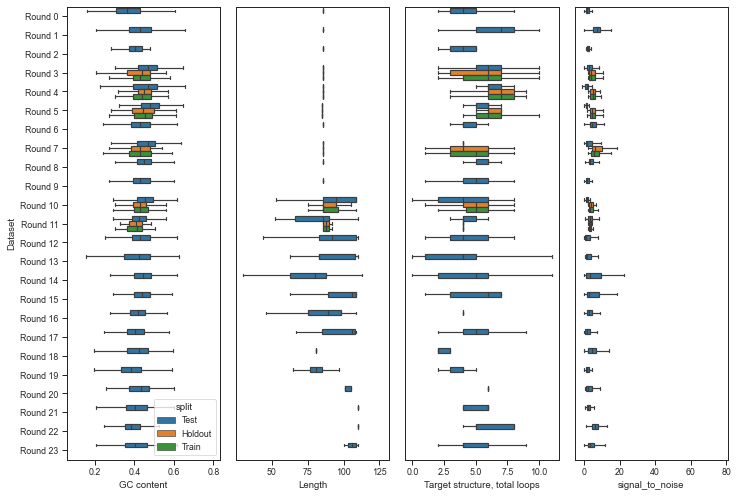

In [62]:
figure(figsize=(15,7))

for i, metric in enumerate(['GC content','Length','Target structure, total loops', 'signal_to_noise']):
    subplot(1,6,i+1)
    sns.boxplot(y='Dataset', x=metric, data=df_filt, order=tmp_order, hue='split', fliersize=0)
    if i!= 0:
        yticks([])
        ylabel('')
        legend([], frameon=False)

tight_layout()
savefig('FIGURES/SI/Figure_S14_Efold_splits_stats.pdf',bbox_inches='tight')
savefig('FIGURES/SI/Figure_S14_Efold_splits_stats.png',dpi=300, bbox_inches='tight')